In [15]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('btc_open.csv')
print(df)

      Unnamed: 0 formatted_date          high           low          open  \
0              0     2019-01-01   3850.913818   3707.231201   3849.216309   
1              1     2019-01-02   3947.981201   3817.409424   3931.048584   
2              2     2019-01-03   3935.685059   3826.222900   3832.040039   
3              3     2019-01-04   3865.934570   3783.853760   3851.973877   
4              4     2019-01-05   3904.903076   3836.900146   3836.519043   
...          ...            ...           ...           ...           ...   
1515        1515     2023-02-24  24103.705078  23007.072266  23200.125000   
1516        1516     2023-02-25  23210.210938  22861.558594  23174.150391   
1517        1517     2023-02-26  23654.367188  23084.220703  23561.451172   
1518        1518     2023-02-27  23857.890625  23205.878906  23521.837891   
1519        1519     2023-02-28  23585.384766  23077.650391  23150.929688   

             close       volume      adjclose  
0      3843.520020   432420

In [17]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['open'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['open'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['open'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['open'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['open'].rolling(window=ma_3).std()
df.dropna(inplace=True)

# df.to_csv("/BOOSTING/bitcoin_processed_close.csv")
df

,Unnamed: 0,formatted_date,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,2019-01-21,3608.840820,3558.537109,3575.081299,3576.032471,5004347059,3576.032471,50.303711,3644.949916,3704.428345,3774.754848,49.537467,165.724656
21,21,2019-01-22,3620.746582,3539.721436,3605.557129,3604.577148,5313623556,3604.577148,81.025146,3641.242397,3674.000140,3763.152030,51.637677,168.752697
22,22,2019-01-23,3623.067871,3565.313965,3584.500244,3585.123047,5433755649,3585.123047,57.753906,3631.617990,3641.863630,3746.649728,55.463195,168.457386
23,23,2019-01-24,3616.087402,3569.092773,3607.390381,3600.865479,5262869046,3600.865479,46.994629,3621.532261,3637.104701,3735.952125,51.931866,169.890592
24,24,2019-01-25,3612.927734,3575.597412,3599.715332,3599.765869,5265847539,3599.765869,37.330322,3614.009033,3630.872001,3723.939814,50.513765,170.194811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1515,2023-02-24,24103.705078,23007.072266,23200.125000,23198.126953,26811744928,23198.126953,1096.632812,24226.281250,23554.157785,23261.075056,536.799356,1086.612093
1516,1516,2023-02-25,23210.210938,22861.558594,23174.150391,23175.375000,16100721565,23175.375000,348.652344,24016.870257,23647.246931,23253.546596,626.863097,1086.642004
1517,1517,2023-02-26,23654.367188,23084.220703,23561.451172,23561.212891,16644534842,23561.212891,570.146484,23906.131417,23773.993443,23282.471819,629.426607,1086.354840
1518,1518,2023-02-27,23857.890625,23205.878906,23521.837891,23522.871094,22660763494,23522.871094,652.011719,23718.815569,23896.851702,23318.879929,486.477502,1080.670089


In [18]:
pre_day =7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','low','close','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['open']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

# test_size = (int)(len(scaled_data_y) * 0.2)
# print(test_size)

# x_train = np.array(x_total[:len(x_total)])
# # x_test = np.array(x_total[len(x_total)-test_size:])
# y_train = np.array(y_total[:len(y_total)])
# # y_test = np.array(y_total[len(y_total)-test_size:])

test_size = (int)(len(scaled_data_y) * 0.2)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

300
(1193, 7, 9) (1193, 1) (300, 7, 9) (300, 1)


In [19]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# model.save("../../model/BOOSTING/GRU_boosting_open.h5")

Epoch 1/120
40/40 [==============================] - 16s 13ms/step - loss: 0.0232
Epoch 2/120
40/40 [==============================] - 1s 13ms/step - loss: 0.0058
Epoch 3/120
40/40 [==============================] - 1s 14ms/step - loss: 0.0053
Epoch 4/120
40/40 [==============================] - 1s 13ms/step - loss: 0.0042
Epoch 5/120
40/40 [==============================] - 1s 13ms/step - loss: 0.0045
Epoch 6/120
40/40 [==============================] - 1s 19ms/step - loss: 0.0033
Epoch 7/120
40/40 [==============================] - 1s 19ms/step - loss: 0.0036
Epoch 8/120
40/40 [==============================] - 1s 16ms/step - loss: 0.0047
Epoch 9/120
40/40 [==============================] - 1s 17ms/step - loss: 0.0037
Epoch 10/120
40/40 [==============================] - 1s 14ms/step - loss: 0.0032
Epoch 11/120
40/40 [==============================] - 1s 16ms/step - loss: 0.0032
Epoch 12/120
40/40 [==============================] - 1s 15ms/step - loss: 0.0028
Epoch 13/120
40/40 [====

In [20]:
# Testing
predict_price = model.predict(x_train)
predict_price = scala_y.inverse_transform(predict_price)
y_train_price = scala_y.inverse_transform(y_train)

error = pd.concat([pd.DataFrame(predict_price,columns=['predict_price'],index=None), pd.DataFrame(y_train_price,columns=['y_train_price'],index=None)], axis=1)
error['error_price'] = error['predict_price'] - error['y_train_price']
print(error)

38/38 [==============================] - 2s 4ms/step
      predict_price  y_train_price  error_price
0       3377.062744    3468.870117   -91.807373
1       3336.821777    3443.896973  -107.075195
2       3289.863037    3485.409180  -195.546143
3       3273.667480    3460.547119  -186.879639
4       3269.380371    3484.625977  -215.245605
...             ...            ...          ...
1188   39114.546875   37713.265625  1401.281250
1189   38438.238281   38472.187500   -33.949219
1190   38443.484375   38528.109375   -84.625000
1191   38580.558594   37748.011719   832.546875
1192   38197.632812   39695.746094 -1498.113281

[1193 rows x 3 columns]


In [21]:
import pickle
from sklearn.linear_model import ElasticNet

elasticnet =  ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True)

In [22]:
elasticnet.fit(error['predict_price'].values.reshape(-1, 1), error['error_price'].values)
# pickle.dump(elasticnet, open("../../model/BOOSTING/booting_elasticnet_open.h5", "wb"))

c:\Users\19521\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.997e+08, tolerance: 3.879e+08
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)

In [23]:
predict_price = model.predict(x_test)
print(predict_price)

10/10 [==============================] - 0s 4ms/step
[[0.5549455 ]
 [0.5323878 ]
 [0.52164406]
 [0.51375616]
 [0.49928933]
 [0.46122277]
 [0.45109814]
 [0.4272289 ]
 [0.41493767]
 [0.42425194]
 [0.4244478 ]
 [0.43404818]
 [0.42973492]
 [0.43037596]
 [0.41661867]
 [0.42152342]
 [0.41732538]
 [0.41607094]
 [0.4198778 ]
 [0.41315538]
 [0.41116023]
 [0.41120255]
 [0.40303156]
 [0.39827892]
 [0.39672205]
 [0.39922613]
 [0.42629176]
 [0.443651  ]
 [0.42198628]
 [0.42136544]
 [0.41653094]
 [0.41611257]
 [0.41663903]
 [0.428212  ]
 [0.427248  ]
 [0.42448914]
 [0.4223933 ]
 [0.4110304 ]
 [0.40132385]
 [0.3856099 ]
 [0.34330642]
 [0.31979018]
 [0.3121053 ]
 [0.30049145]
 [0.29169372]
 [0.26940745]
 [0.27095494]
 [0.28426707]
 [0.28996357]
 [0.2773603 ]
 [0.28050584]
 [0.28622732]
 [0.28541845]
 [0.28263858]
 [0.2767659 ]
 [0.26987764]
 [0.26404932]
 [0.25545782]
 [0.2532824 ]
 [0.24853674]
 [0.24556804]
 [0.25248516]
 [0.25869107]
 [0.26509053]
 [0.27899736]
 [0.2882467 ]
 [0.28779727]
 [0.27791

In [24]:



predict_error = elasticnet.predict(predict_price)
index=0
predict_price = scala_y.inverse_transform(predict_price)
for error in predict_error:
    predict_price[index]+=error
    index+=1
print(predict_price)



[[38927.2  ]
 [37480.16 ]
 [36790.965]
 [36284.97 ]
 [35356.945]
 [32915.04 ]
 [32265.56 ]
 [30734.39 ]
 [29945.928]
 [30543.424]
 [30555.988]
 [31171.836]
 [30895.146]
 [30936.27 ]
 [30053.762]
 [30368.393]
 [30099.096]
 [30018.625]
 [30262.828]
 [29831.598]
 [29703.611]
 [29706.326]
 [29182.17 ]
 [28877.297]
 [28777.426]
 [28938.059]
 [30674.273]
 [31787.84 ]
 [30398.084]
 [30358.26 ]
 [30048.133]
 [30021.297]
 [30055.066]
 [30797.453]
 [30735.615]
 [30558.639]
 [30424.193]
 [29695.283]
 [29072.625]
 [28064.6  ]
 [25350.9  ]
 [23842.373]
 [23349.4  ]
 [22604.39 ]
 [22040.031]
 [20610.404]
 [20709.672]
 [21563.623]
 [21929.045]
 [21120.564]
 [21322.346]
 [21689.37 ]
 [21637.482]
 [21459.158]
 [21082.438]
 [20640.564]
 [20266.688]
 [19715.557]
 [19576.008]
 [19271.582]
 [19081.145]
 [19524.865]
 [19922.965]
 [20333.48 ]
 [21225.58 ]
 [21818.91 ]
 [21790.08 ]
 [21156.348]
 [20518.479]
 [20015.254]
 [20095.785]
 [20462.375]
 [20809.707]
 [21064.916]
 [21096.85 ]
 [22000.936]
 [23074.74 ]

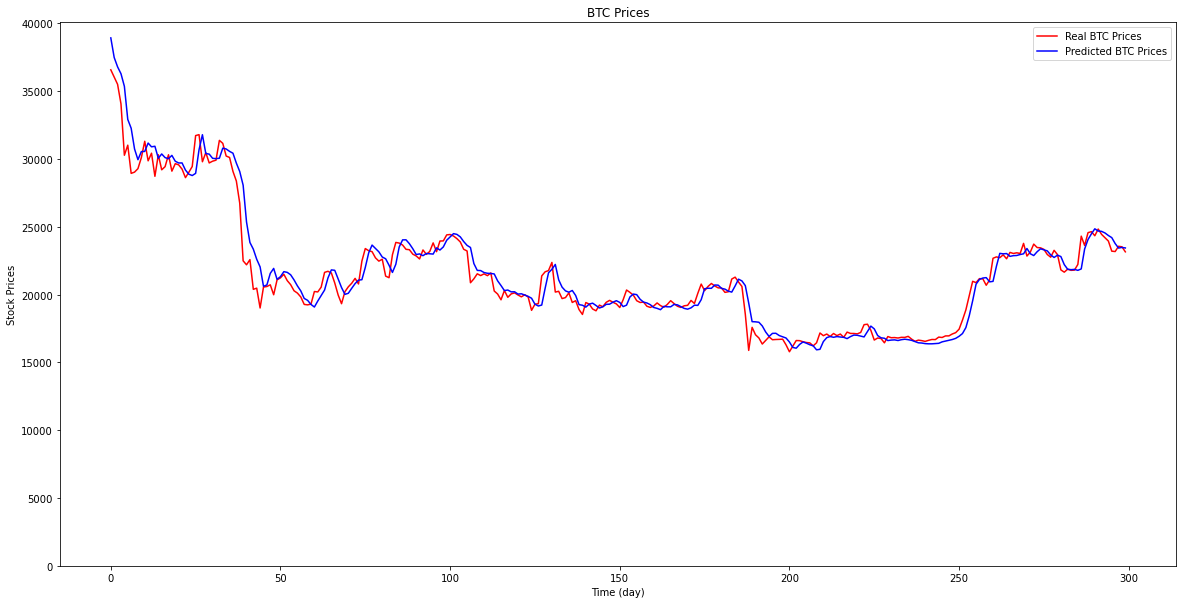

In [25]:
y_test = scala_y.inverse_transform(y_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, color="red", label=f"Real BTC Prices")
plt.plot(predict_price[0:], color="blue", label=f"Predicted BTC Prices")
plt.title(f"BTC Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

TEST

In [26]:
mae = mean_absolute_error(y_test, predict_price)
mape = mean_absolute_percentage_error(y_test, predict_price)
mse = mean_squared_error(y_test, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 609.31
MAPE: 2.76%
MSE: 925456.20
RMSE: 962.01
R2: 0.95


In [27]:
# predict_price_test = model.predict(x_test)
# predict_price_test = scala_y.inverse_transform(predict_price_test)
# y_test = scala_y.inverse_transform(y_test)



In [28]:
# validate = []
# for predict in predict_price_test:
#     predict= elasticnet.predict(np.array([predict]).reshape(-1,1))[0]
#     validate.append(predict)
# df_predict = pd.concat([pd.DataFrame(predict_price_test,columns=['predict_price_test'],index=None), pd.DataFrame(y_test,columns=['y_test'],index=None)], axis=1)
# df_predict['final_predict'] = df_predict['predict_price_test'] + validate
# print(df_predict.to_csv('result.csv'))